In [1]:

# Dataframe and Plotting libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


pd.set_option('display.max_columns', None)

# LOAD the Dataset

In [44]:
# Load the files into a Pandas Dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
# print the shape of the datasets.
print('Train data shape :', train.shape)
print('Test data shape :', test.shape)

Train data shape : (373, 12)
Test data shape : (558, 11)


In [46]:
train

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
0,2022-05-04 10:25:50.588042+00,UONSDA CHURCH MOGERE MWAYO TITHE,Rent / Mortgage,1700,2022-05-04 13:56:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_04mk78fa
1,2021-10-25 16:18:38.586837+00,PARK N GO,Transport & Fuel,100,2021-10-24 14:12:00+00,False,25.0,Female,4,90000,ID_U9WZMGJZ,ID_04xkfb07
2,2022-05-20 14:17:30.917297+00,SAFARICOM OFFERS TUNUKIWA,Data & WiFi,20,2022-05-27 12:46:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_051urwuw
3,2022-04-12 15:59:14.139347+00,ZILLIONS CREDIT LIMITED,Loan Repayment,3800,2022-02-07 12:16:00+00,False,NaN,Male,5,252000,ID_3JA0MAFB,ID_0e1om7rz
4,2022-05-04 10:24:26.709045+00,MICHAEL MUSEMBI,Bills & Fees,60,2022-05-04 15:28:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_0kfcoawb
...,...,...,...,...,...,...,...,...,...,...,...,...
368,2021-08-06 11:28:03.723042+00,ONESMUS GAKURU,Miscellaneous,500,2021-08-26 13:38:00+00,True,27.0,Female,2,8000,ID_L8QMYB09,ID_zr5x8yjs
369,2022-04-12 15:57:05.758311+00,GLADWELL MBURU,Miscellaneous,400,2022-04-03 08:39:00+00,True,NaN,Male,5,750000,ID_D8FOVVBB,ID_zty81sq8
370,2021-12-01 08:33:13.82067+00,SAFARICOM LIMITED,Data & WiFi,500,2021-01-15 15:40:00+00,False,NaN,Male,3,200000,ID_ECX9BS4A,ID_zx5ajeqe
371,2021-10-05 12:29:13.14963+00,EQUITY PAYBILL ACCOUNT,Bills & Fees,14000,2021-10-08 10:33:00+00,True,25.0,Female,4,90000,ID_U9WZMGJZ,ID_zx9hnvvb


<BarContainer object of 373 artists>

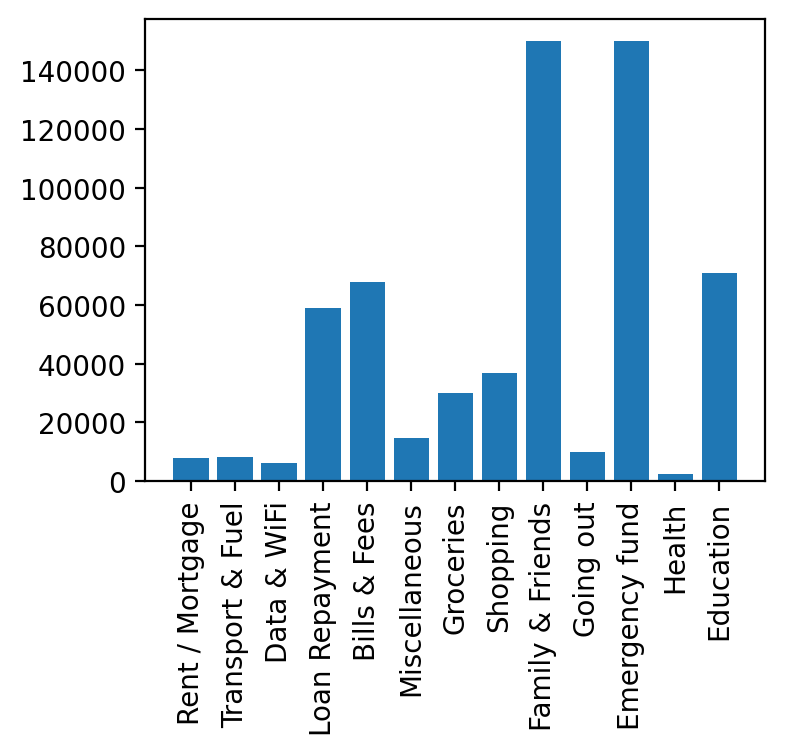

In [5]:
# Bar graph of the purchase_value vs the target
plt.figure(dpi=200, figsize=(4,3))
plt.xticks(rotation=90)
plt.bar(data=train, x='MERCHANT_CATEGORIZED_AS', height='PURCHASE_VALUE')

In [6]:
labels_train = train['MERCHANT_CATEGORIZED_AS'].astype('category').cat.categories.tolist()
replace_map_train = {'MERCHANT_CATEGORIZED_AS' : {k: v for k,v in zip(labels_train,list(range(0,len(labels_train)+1)))}}
print("Train data: ", replace_map_train)

Train data:  {'MERCHANT_CATEGORIZED_AS': {'Bills & Fees': 0, 'Data & WiFi': 1, 'Education': 2, 'Emergency fund': 3, 'Family & Friends': 4, 'Going out': 5, 'Groceries': 6, 'Health': 7, 'Loan Repayment': 8, 'Miscellaneous': 9, 'Rent / Mortgage': 10, 'Shopping': 11, 'Transport & Fuel': 12}}


In [7]:
train_data_corr = train.copy()

In [8]:
# We can also use the .isnull() method to check for empty values
print('Missing values for Train:', train.isnull().sum())
print('')
print('Missing values for Test:', test.isnull().sum())

Missing values for Train: MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
MERCHANT_CATEGORIZED_AS                    0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 312
USER_GENDER                                6
USER_HOUSEHOLD                             0
USER_INCOME                                0
USER_ID                                    0
Transaction_ID                             0
dtype: int64

Missing values for Test: MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 473
USER_GENDER                                5
USER_HOUSEHOLD                             0
USER_INCOME                        

In [9]:
train[train['USER_GENDER'].isnull()]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
35,2021-11-30 10:51:36.702996+00,IDEAL APPLIANCES,Bills & Fees,24995,2021-05-06 14:14:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_3xlptxy6
137,2021-11-30 10:52:38.553994+00,QUICK MART,Shopping,3298,2021-06-19 15:05:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_dhp3d403
280,2021-08-06 11:28:03.723042+00,EQUITY PAYBILL,Shopping,4000,2021-07-25 10:54:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_qvgzrt0r
309,2021-11-30 10:52:38.553994+00,NAOMI WANJOHI,Family & Friends,1028,2021-05-13 14:28:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_u02b0hl6
312,2021-11-30 10:51:36.702996+00,POA,Data & WiFi,1500,2021-07-21 17:46:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_uvhgthza
361,2021-11-30 10:51:36.702996+00,MIRIAM MUNGAI,Family & Friends,1600,2021-06-11 18:25:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_yxz5etfz


In [10]:
test[test['USER_GENDER'].isnull()]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
124,2021-08-06 11:28:16.857538+00,ACCESS AFYA,1,2021-08-05 09:32:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_8oyhw5j0
138,2021-11-30 10:51:36.702996+00,PETER INDIMULI,1028,2021-04-08 12:07:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_9au0g3qv
374,2021-11-30 10:51:36.702996+00,MICHELLE RODROT,827,2021-07-22 13:36:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_p5ajidvp
395,2021-11-30 10:51:36.702996+00,DORCAS WANJOHI,2600,2021-06-07 14:05:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_qd7dgqor
550,2021-11-30 10:52:38.553994+00,POA,1500,2021-05-22 19:11:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_zqi8lti6


In [11]:
train.USER_GENDER.value_counts()

Male      197
Female    170
Name: USER_GENDER, dtype: int64

In [12]:
test.USER_GENDER.value_counts()

Male      307
Female    246
Name: USER_GENDER, dtype: int64

In [13]:
train["USER_GENDER"] = train["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)
test["USER_GENDER"] = test["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)

In [14]:
# Impute the missing age entries with the median of that column
train_median_value = np.median(train['USER_AGE'].dropna())
train['USER_AGE'] = train['USER_AGE'].fillna(train_median_value)

test_median_value = np.median(test['USER_AGE'].dropna())
test['USER_AGE'] = test['USER_AGE'].fillna(test_median_value)

In [15]:
train["train"] = 1
test["train"] = 0

In [16]:
all_data = pd.concat([train, test])

In [17]:
all_data = pd.get_dummies(all_data, prefix_sep="_", columns=['MERCHANT_NAME'])

In [18]:
train = all_data[all_data["train"] == 1]
test = all_data[all_data["train"] == 0]

In [19]:
print("Train: ", train.shape)
print("Test: ", test.shape)

Train:  (373, 452)
Test:  (558, 452)


In [20]:
train = train.drop(['MERCHANT_CATEGORIZED_AT','PURCHASED_AT','USER_ID', 'Transaction_ID', "train"], axis=1)
test = test.drop(['MERCHANT_CATEGORIZED_AT','PURCHASED_AT','USER_ID', "train", "MERCHANT_CATEGORIZED_AS"], axis=1)

In [21]:
# Based on our data set, this function converts boolean to binary entries
def create_binary_cols(content):
  if content == False:
    content = 0
  elif content == True:
    content = 1
  elif content == 'N':
    content = 0
  elif content == 'Y':
    content = 1
  elif content == 'Male':
    content = 0
  elif content == 'Female':
    content = 1
  return content

In [22]:
# Gender column convert:
train['USER_GENDER'] = train['USER_GENDER'].apply(create_binary_cols)
test['USER_GENDER'] = test['USER_GENDER'].apply(create_binary_cols)

# Is_purchase_paid_via_mpesa_send_money column convert:
train['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'] = train['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'].apply(create_binary_cols)
test['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'] = test['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'].apply(create_binary_cols)

In [23]:
# Separate the features from the target in the training data
X = train.drop(["MERCHANT_CATEGORIZED_AS"], axis=1)
y = train["MERCHANT_CATEGORIZED_AS"]

In [48]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_resample(X, y)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=101)

In [25]:
# Creating a Decision tree classifier
model_dtree = DecisionTreeClassifier(max_depth=5, random_state=101,
                                     max_features = None, min_samples_leaf=8)

# Training the model on the training dataset
model_dtree.fit(X_train, y_train)

# Predict
y_pred = model_dtree.predict(X_val)

# Calculate accuracy
print("ACCURACY OF THE MODEL: ", accuracy_score(y_val, y_pred))

# Classification report
print(classification_report(y_val, y_pred))

ACCURACY OF THE MODEL:  0.34210526315789475
                  precision    recall  f1-score   support

    Bills & Fees       0.36      0.67      0.47         6
     Data & WiFi       1.00      0.50      0.67         4
Family & Friends       0.00      0.00      0.00         6
       Going out       0.29      0.50      0.36         4
       Groceries       0.28      0.83      0.42         6
          Health       0.00      0.00      0.00         1
   Miscellaneous       0.00      0.00      0.00         4
        Shopping       0.00      0.00      0.00         3
Transport & Fuel       0.00      0.00      0.00         4

        accuracy                           0.34        38
       macro avg       0.21      0.28      0.21        38
    weighted avg       0.24      0.34      0.25        38



/Users/da_m1_40_/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/da_m1_40_/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/da_m1_40_/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Creating a RF classifier
clf = RandomForestClassifier() 
 
# Training the model on the training dataset
clf.fit(X_train, y_train)
 
# Performing predictions on the test dataset
y_pred = clf.predict(X_val)

# Calculate accuracy
print("ACCURACY OF THE MODEL: ", accuracy_score(y_val, y_pred))

# Classification report
print(classification_report(y_val, y_pred))


ACCURACY OF THE MODEL:  0.6052631578947368
                  precision    recall  f1-score   support

    Bills & Fees       0.62      0.83      0.71         6
     Data & WiFi       1.00      1.00      1.00         4
  Emergency fund       0.00      0.00      0.00         0
Family & Friends       0.80      0.67      0.73         6
       Going out       0.40      0.50      0.44         4
       Groceries       0.29      0.33      0.31         6
          Health       0.00      0.00      0.00         1
   Miscellaneous       1.00      0.50      0.67         4
        Shopping       1.00      0.33      0.50         3
Transport & Fuel       0.60      0.75      0.67         4

        accuracy                           0.61        38
       macro avg       0.57      0.49      0.50        38
    weighted avg       0.66      0.61      0.61        38



/Users/da_m1_40_/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/da_m1_40_/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/da_m1_40_/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/da_m1_40_/anacond

In [27]:
train_data_corr.replace(replace_map_train, inplace=True)

In [28]:
X = train.drop(["MERCHANT_CATEGORIZED_AS"], axis=1)
y = train_data_corr["MERCHANT_CATEGORIZED_AS"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=101)

In [29]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [30]:
expected_y  = y_val
predicted_y = model.predict(X_val)

In [38]:
print(classification_report(expected_y, predicted_y))
print(accuracy_score(y_val, predicted_y))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       0.80      1.00      0.89         4
           4       1.00      0.50      0.67         6
           5       0.33      0.25      0.29         4
           6       0.29      0.33      0.31         6
           7       0.00      0.00      0.00         1
           9       0.67      0.50      0.57         4
          11       0.00      0.00      0.00         3
          12       0.60      0.75      0.67         4

    accuracy                           0.55        38
   macro avg       0.47      0.48      0.45        38
weighted avg       0.53      0.55      0.51        38

0.5526315789473685


/Users/da_m1_40_/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/da_m1_40_/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/da_m1_40_/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: xlabel='MERCHANT_CATEGORIZED_AS'>

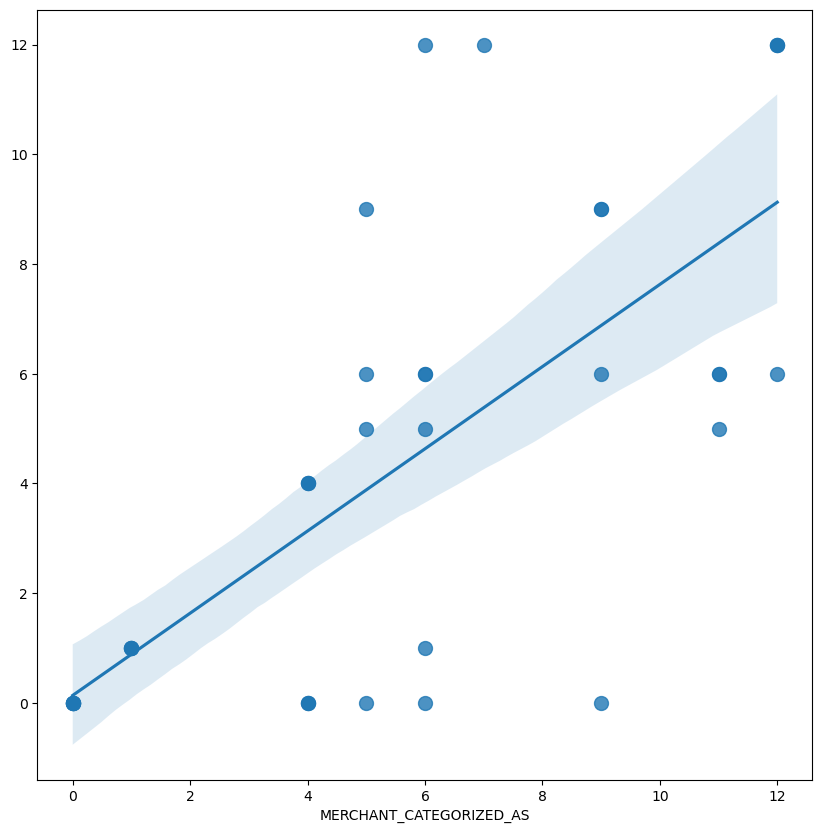

In [32]:
plt.figure(figsize=(10,10))
sns.regplot(x=expected_y, y=predicted_y, fit_reg=True, scatter_kws={"s": 100})

In [33]:
# Get the predicted result for the test Data
predictions = clf.predict(test.drop("Transaction_ID", axis=1))

In [34]:
test["predictions"] = predictions

In [35]:
test[["Transaction_ID",  "predictions"]].head()

,Transaction_ID,predictions
0,ID_00x9h2yx,Emergency fund
1,ID_01db594f,Going out
2,ID_07pm99no,Miscellaneous
3,ID_09jryhkd,Miscellaneous
4,ID_0ccv924c,Bills & Fees


In [36]:
test[["Transaction_ID",  "predictions"]]["predictions"].nunique()

11